In [ ]:
import pandas as pd 
import numpy as np 
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cro
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import pairwise_distances_argmin, RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, f1_score, classification_report, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

In [2]:
transactions = pd.read_csv('/Users/valentine/mlbd-2025/project/Lernnavi/Lernnavi_Data/transactions.csv.gz')
documents = pd.read_csv('/Users/valentine/mlbd-2025/project/Lernnavi/Lernnavi_Data/documents.csv.gz')

In [3]:
# Get question difficulties

def get_difficulty(doc):
    res = None
    doc = json.loads(doc)
    if doc.get('metaData') != None:
        res = doc.get('metaData').get('estimatedDifficulty')
    return res

documents['difficulty'] = documents['content'].apply(lambda doc: get_difficulty(doc))

In [4]:
# Merge transactions and documents

documents.rename(columns={'version': 'document_version'}, inplace=True)
difficulty = pd.merge(transactions, documents, on=['document_id', 'document_version'])
difficulty.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,challenge_name,title,type_y,created_time,author_id,content,status,version_comment,topic_id_y,difficulty
0,688413,88fdcaad-f73b-46a2-b561-d262f2441442,393211,awd0i1DlVtg6kuMZSkpmHa,75002,PARTIAL,"{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""highlighted...",2021-05-21 07:58:27.312000000,2021-05-21 08:03:43.020000000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3A_STIL_RHET_16,MULTI_COLOR_HIGHLIGHT,2021-04-12 19:46:20.635,29.0,"{""id"": ""awd0i1DlVtg6kuMZSkpmHa"", ""type"": ""MULT...",LIVE,NaN,2045,2.0
1,688414,a75eb7b4-b2c2-47d4-9200-27980c175037,393211,arhWF3BT53V9W8cGOaZVPX,75012,PARTIAL,"{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""highlighted...",2021-05-21 08:04:05.067000000,2021-05-21 08:07:21.288999936,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_11,MULTI_COLOR_HIGHLIGHT,2021-04-12 19:49:26.297,29.0,"{""id"": ""arhWF3BT53V9W8cGOaZVPX"", ""type"": ""MULT...",LIVE,NaN,4256,3.0
2,688415,61eb829d-bdda-4107-86af-ad9a14a7bdc9,393211,9wk5dtV2mF59odW0wCEYYc,75003,PARTIAL,"{""type"": ""CLOZE_TEXT"", ""clozeInputs"": [""Person...",2021-05-21 08:07:37.048000000,2021-05-21 08:13:30.953999872,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_5,CLOZE_TEXT_INPUT,2021-04-12 19:48:16.679,29.0,"{""id"": ""9wk5dtV2mF59odW0wCEYYc"", ""type"": ""CLOZ...",LIVE,NaN,4256,3.0
3,688416,30ff0d8a-865d-460b-9177-b698a52b0d5c,393211,afilxZ8LycP5LReULeKngW,75009,CORRECT,"{""type"": ""DND_PAIRS"", ""input"": [""<p>Ich gehe i...",2021-05-21 08:13:38.943000000,2021-05-21 08:22:13.975000064,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_7,DND_PAIRS,2021-04-12 19:49:06.392,29.0,"{""id"": ""afilxZ8LycP5LReULeKngW"", ""type"": ""DND_...",LIVE,NaN,4256,3.0
4,688417,0adedf3b-ba35-4497-8c6b-b5c2f6fcbbf3,393211,76m6v05NCeX8x2Wr5tKRE3,75007,CORRECT,"{""type"": ""DND_PAIRS"", ""input"": [""<p>Kleiner Ma...",2021-05-21 08:22:19.391000000,2021-05-21 08:22:55.366000128,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_4,DND_PAIRS,2021-04-12 19:48:42.300,29.0,"{""id"": ""76m6v05NCeX8x2Wr5tKRE3"", ""type"": ""DND_...",LIVE,NaN,4256,2.0


In [5]:
# Create a perceived difficulty variable based on evaluation and time to answer 

difficulty['date'] = pd.to_datetime(difficulty['start_time'])
difficulty['year_week'] = difficulty['date'].dt.strftime('%Y-%U')
difficulty['time_to_answer'] = (pd.to_datetime(difficulty['commit_time']) - pd.to_datetime(difficulty['start_time'])).dt.total_seconds()

# Map evaluation values to weights
eval_map = {
    'CORRECT': 0.5,
    'PARTIAL': 1.0,
    'WRONG': 1.5,
    np.nan: 1.2  # Assume NaN means unclear result, treat as partially wrong
}
difficulty['evaluation_weight'] = difficulty['evaluation'].map(eval_map)

# Normalize time_to_answer (already in seconds) using log transform + z-score
difficulty['log_time'] = np.log1p(difficulty['time_to_answer'])
difficulty['normalized_time'] = (difficulty['log_time'] - difficulty['log_time'].mean()) / difficulty['log_time'].std()

# Compute perceived difficulty as interaction of time and evaluation weight
difficulty['perceived_difficulty'] = difficulty['normalized_time'] * difficulty['evaluation_weight']

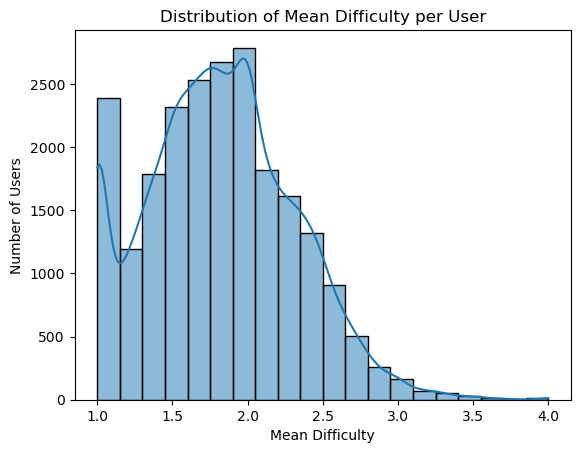

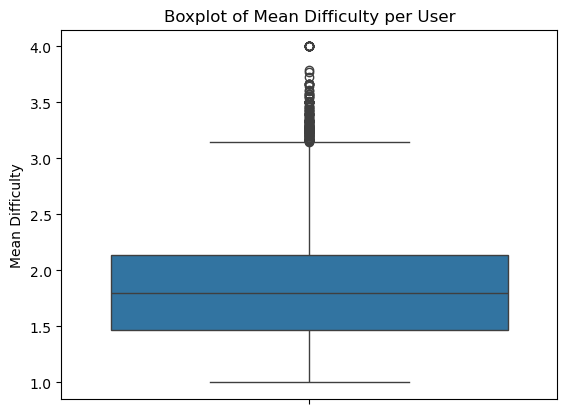

In [6]:
# Observe distribution of question difficulty 

# Mean difficulty
mean_diff = difficulty.groupby(['user_id', 'year_week'])['difficulty'].mean().reset_index(name='mean_difficulty')

# Count of each difficulty
counts = pd.pivot_table(
    difficulty,
    index=['user_id', 'year_week'],
    columns='difficulty',
    aggfunc='size',
    fill_value=0
).reset_index()

# Rename columns
counts.columns.name = None
counts = counts.rename(columns={
    1: 'difficulty_1_count',
    2: 'difficulty_2_count',
    3: 'difficulty_3_count',
    4: 'difficulty_4_count'
})

# Merge
weekly_difficulty = pd.merge(mean_diff, counts, on=['user_id', 'year_week'])
user_mean_difficulty = weekly_difficulty.groupby('user_id')['mean_difficulty'].mean().reset_index()

sns.histplot(user_mean_difficulty['mean_difficulty'], bins=20, kde=True)
plt.title('Distribution of Mean Difficulty per User')
plt.xlabel('Mean Difficulty')
plt.ylabel('Number of Users')
plt.show()

sns.boxplot(y=user_mean_difficulty['mean_difficulty'])
plt.title('Boxplot of Mean Difficulty per User')
plt.ylabel('Mean Difficulty')
plt.show()

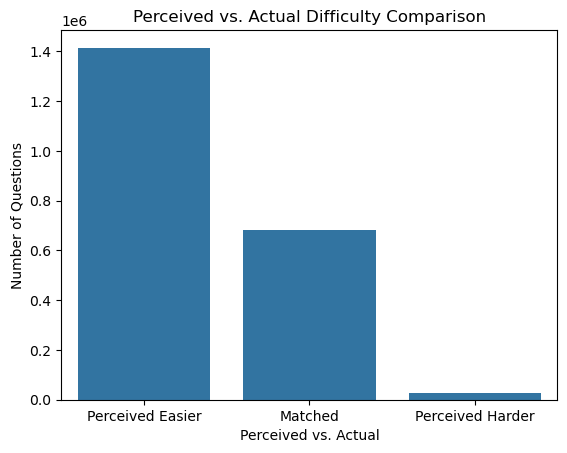

In [7]:
# Show perceived vs actual difficulty

threshold = 0.5
difficulty['perceived_vs_actual'] = difficulty.apply(
    lambda row: -1 if row['perceived_difficulty'] < row['difficulty'] - threshold
    else (1 if row['perceived_difficulty'] > row['difficulty'] + threshold 
    else 0),
    axis=1
)
# Create label names for readability
label_map = {-1: 'Perceived Easier', 0: 'Matched', 1: 'Perceived Harder'}
difficulty['perceived_label'] = difficulty['perceived_vs_actual'].map(label_map)

# Plot
sns.countplot(data=difficulty, x='perceived_label', order=['Perceived Easier', 'Matched', 'Perceived Harder'])
plt.title('Perceived vs. Actual Difficulty Comparison')
plt.xlabel('Perceived vs. Actual')
plt.ylabel('Number of Questions')
plt.grid(False)
plt.show()

### Model engagement with difficulty

In [8]:
# Get engagement variable

user_week_features = pd.read_csv('user_week_features.csv')

# Aggregate actual and perceived difficulty per user-week
weekly_difficulty_stats = difficulty.groupby(['user_id', 'year_week']).agg(
    mean_difficulty=('difficulty', 'mean'),
    std_difficulty=('difficulty', 'std'),
    mean_perceived=('perceived_difficulty', 'mean'),
    std_perceived=('perceived_difficulty', 'std'),
    perceived_minus_actual=('perceived_difficulty', lambda x: x.mean())  # we'll subtract later
).reset_index()

# Add perceived - actual difference
weekly_difficulty_stats['perceived_vs_actual_diff'] = (
    weekly_difficulty_stats['mean_perceived'] - weekly_difficulty_stats['mean_difficulty']
)

df_model = pd.merge(user_week_features, weekly_difficulty_stats, on=['user_id', 'year_week'], how='left').dropna()

#### Difficulty features only

In [10]:
# Define features and target
features = [
    'mean_difficulty',
    'std_difficulty',
    'mean_perceived',
    'std_perceived',
    'perceived_vs_actual_diff'
]

X = df_model[features]
y = df_model['engaged_next_week']

In [11]:
MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=600, class_weight='balanced',
                                            n_jobs=-1, random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42)
}

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:,1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append( f1_score(y.iloc[te], yhat) )
    return np.mean(aucs), np.mean(f1s)

tscv = TimeSeriesSplit(n_splits=5)
rows = []

numeric_cols = X.select_dtypes(include='number').columns

pre = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
])

for name, clf in MODELS.items():

    pipe = make_pipeline(pre, clf)
    auc2, f12 = cross_val(pipe, X, y, tscv)
    rows.append({'model':name, 'AUC':auc2, 'F1':f12})

leader = pd.DataFrame(rows).sort_values(['AUC'], ascending=False).reset_index(drop=True)
display(leader.style.background_gradient(cmap='viridis', subset=['AUC','F1']))

best = leader.iloc[0]
print(f"\nBest: {best['model']} AUC={best['AUC']:.3f}")

# --------------------- 5 · fit on FULL data & save -----------------
best_clf = MODELS[best['model']]
final_pipe = make_pipeline(pre, best_clf)
final_pipe.fit(X, y)

,model,AUC,F1
0,Logistic,0.546949,0.503477
1,GradientBoost,0.531159,0.215981
2,RandomForest,0.519483,0.366389
3,Dummy,0.500000,0.000000



Best: Logistic AUC=0.547


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['mean_difficulty', 'std_difficulty', 'mean_perceived', 'std_perceived',
       'perceived_vs_actual_diff'],
      dtype='object'))])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

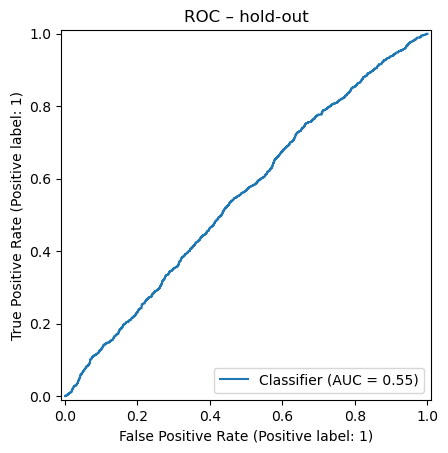

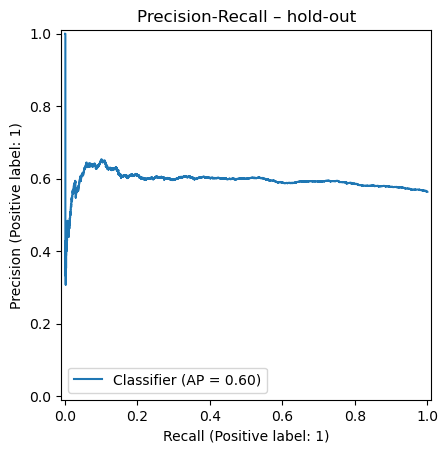

In [12]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
final_pipe.fit(X_train, y_train)
prob = final_pipe.predict_proba(X_hold)[:,1]

RocCurveDisplay.from_predictions(y_hold, prob)
plt.title('ROC – hold-out'); plt.show()

PrecisionRecallDisplay.from_predictions(y_hold, prob)
plt.title('Precision-Recall – hold-out'); plt.show()

With difficulty features only the model doesn't learn meaningful patterns

#### Difficulty and user features

In [21]:
# Drop ID columns from features
X = df_model.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
y = df_model['engaged_next_week']

# -------------------------
# Modeling setup
# -------------------------
MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42)
}

numeric_cols = X.select_dtypes(include='number').columns

pre = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
])

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:,1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append(f1_score(y.iloc[te], yhat))
    return np.mean(aucs), np.mean(f1s)

tscv = TimeSeriesSplit(n_splits=5)
results = []

# -------------------------
# Train & Evaluate
# -------------------------
best_auc = -np.inf
best_pipe = None
best_model_name = None

for name, clf in MODELS.items():
    pipe = make_pipeline(pre, clf)
    auc, f1 = cross_val(pipe, X, y, tscv)
    results.append({'model': name, 'AUC': auc, 'F1': f1})

    # Save best pipeline
    if auc > best_auc:
        best_auc = auc
        best_pipe = pipe
        best_model_name = name

leaderboard = pd.DataFrame(results).sort_values('AUC', ascending=False).reset_index(drop=True)
display(leaderboard.style.background_gradient(cmap='YlGnBu', subset=['AUC', 'F1']))

,model,AUC,F1
0,RandomForest,0.727988,0.555193
1,GradientBoost,0.724993,0.522468
2,Logistic,0.589084,0.543192
3,Dummy,0.500000,0.000000


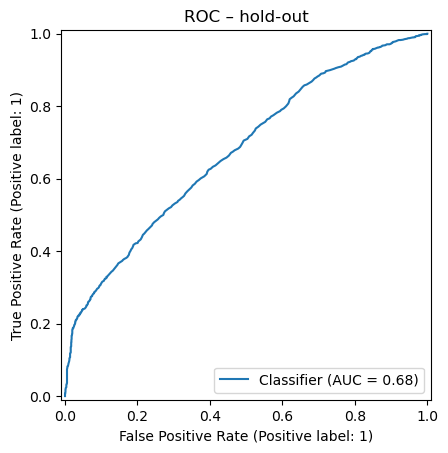

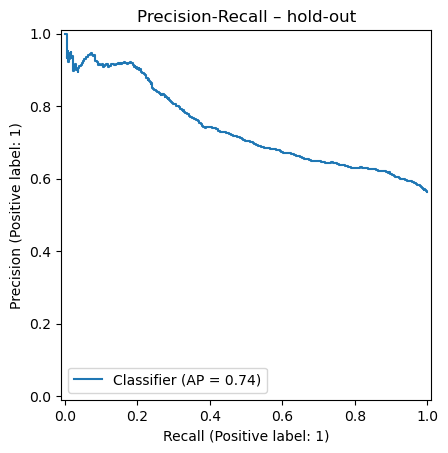

In [22]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
best_pipe.fit(X_train, y_train)
prob = best_pipe.predict_proba(X_hold)[:,1]

RocCurveDisplay.from_predictions(y_hold, prob)
plt.title('ROC – hold-out'); plt.show()

PrecisionRecallDisplay.from_predictions(y_hold, prob)
plt.title('Precision-Recall – hold-out'); plt.show()

By combining difficulty features with user features the model improves significantly

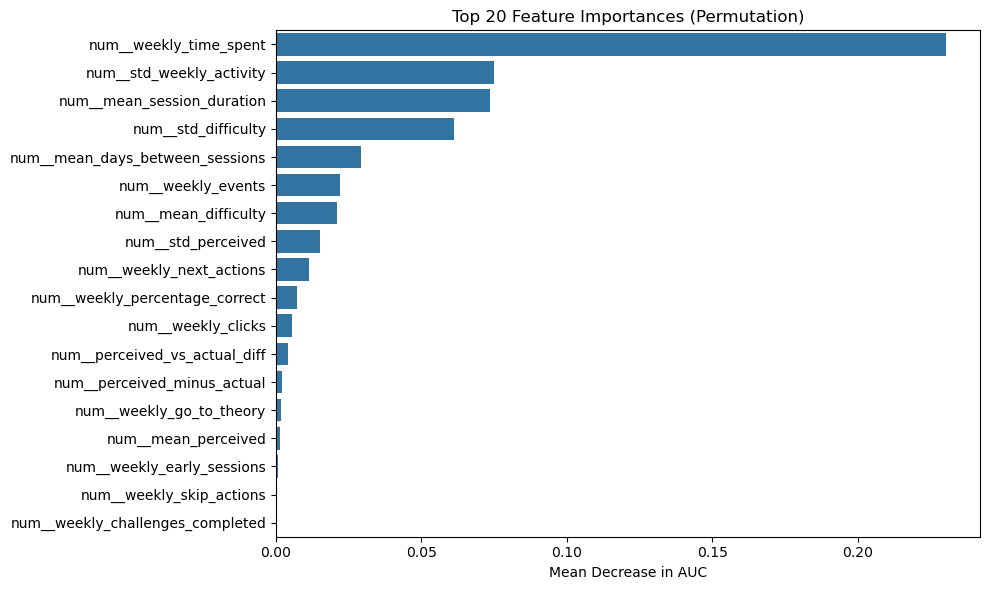

In [24]:
# Examine features importances in the model 

# Refit the best pipeline on full data
best_pipe.fit(X, y)

# Extract the final model step (last in pipeline)
final_model = best_pipe.steps[-1][1]  # grabs the actual model (e.g., RandomForestClassifier)
preprocessor = best_pipe.named_steps['columntransformer']

# Preprocess X
X_processed = preprocessor.transform(X)

# Run permutation importance
r = permutation_importance(final_model, X_processed, y, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature names
feature_names = preprocessor.get_feature_names_out()
sorted_idx = r.importances_mean.argsort()[::-1]

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x=r.importances_mean[sorted_idx][:20], y=feature_names[sorted_idx][:20])
plt.title("Top 20 Feature Importances (Permutation)")
plt.xlabel("Mean Decrease in AUC")
plt.tight_layout()
plt.show()


,user_id,year_week,dropout_risk,mean_perceived_difficulty,engaged_next_week
8176,394927,2022-18,1.000,0.821833,1
6014,394680,2021-36,1.000,NaN,1
20618,410825,2022-33,0.998,0.234391,1
7278,394804,2021-42,0.998,-0.252541,1
7089,394776,2021-48,0.998,0.013743,1
8069,394922,2021-47,0.998,0.614222,1
8658,394975,2021-48,0.998,-0.224346,1
7052,394774,2022-13,0.998,-0.079689,1
8232,394952,2021-49,0.998,0.046213,1
8446,394963,2021-49,0.996,0.356074,1


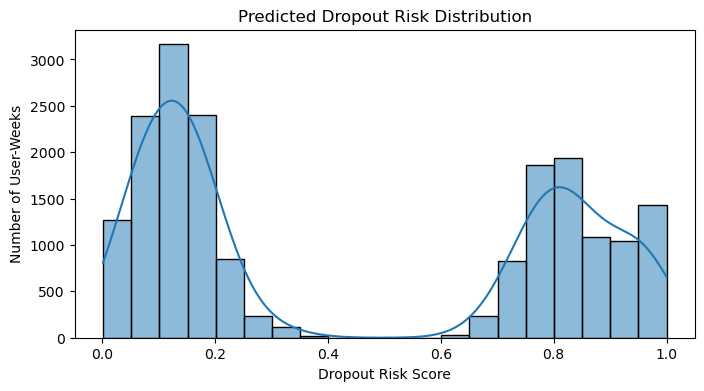

In [25]:
# Predict risk (probability of disengagement)
risk_scores = best_pipe.predict_proba(X)[:, 1]

# Add to original user-week dataframe
dashboard = df_model.copy()
dashboard['dropout_risk'] = risk_scores
dashboard['engaged_next_week'] = y.values
dashboard['mean_perceived_difficulty'] = difficulty.groupby(['user_id', 'year_week'])['perceived_difficulty'].mean().reset_index(drop=True)

# Show top 10 most at-risk learners
top_risks = dashboard.sort_values(by='dropout_risk', ascending=False).head(10)
display(top_risks[['user_id', 'year_week', 'dropout_risk', 'mean_perceived_difficulty', 'engaged_next_week']])

plt.figure(figsize=(8, 4))
sns.histplot(dashboard['dropout_risk'], bins=20, kde=True)
plt.title("Predicted Dropout Risk Distribution")
plt.xlabel("Dropout Risk Score")
plt.ylabel("Number of User-Weeks")
plt.show()

/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_75008/2846775705.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  difficulty_risk = dashboard.groupby('difficulty_bin')['dropout_risk'].mean().reset_index()


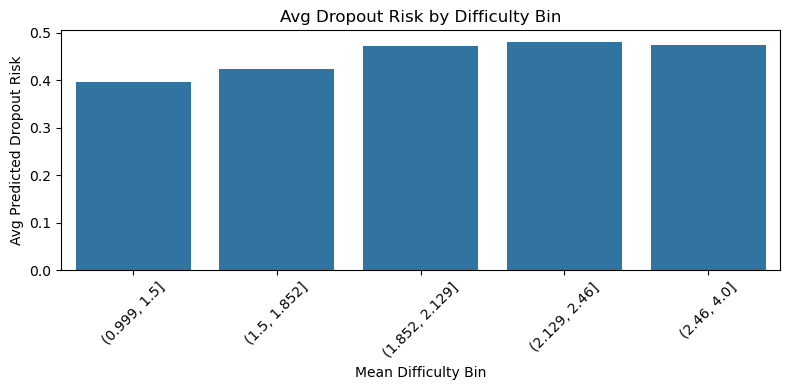

/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_75008/2846775705.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perceived_risk = dashboard.groupby('perceived_bin')['dropout_risk'].mean().reset_index()


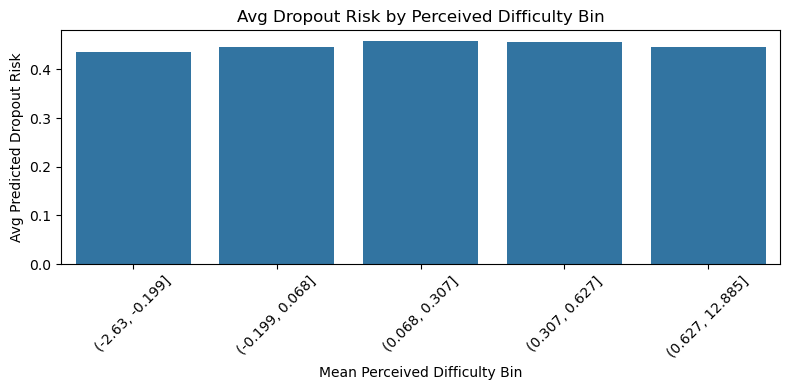

In [27]:
# Bin difficulty into quantiles
dashboard['difficulty_bin'] = pd.qcut(dashboard['mean_difficulty'], q=5)
difficulty_risk = dashboard.groupby('difficulty_bin')['dropout_risk'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='difficulty_bin', y='dropout_risk', data=difficulty_risk)
plt.xticks(rotation=45)
plt.title("Avg Dropout Risk by Difficulty Bin")
plt.xlabel("Mean Difficulty Bin")
plt.ylabel("Avg Predicted Dropout Risk")
plt.tight_layout()
plt.show()

# Repeat for perceived difficulty
dashboard['perceived_bin'] = pd.qcut(dashboard['mean_perceived_difficulty'], q=5)
perceived_risk = dashboard.groupby('perceived_bin')['dropout_risk'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='perceived_bin', y='dropout_risk', data=perceived_risk)
plt.xticks(rotation=45)
plt.title("Avg Dropout Risk by Perceived Difficulty Bin")
plt.xlabel("Mean Perceived Difficulty Bin")
plt.ylabel("Avg Predicted Dropout Risk")
plt.tight_layout()
plt.show()


### Evaluate difficulty impact on weekly time spent

In [9]:
y = df_model['weekly_time_spent']  # Target

difficulty_features = [
    'mean_difficulty', 'std_difficulty',
    'mean_perceived', 'std_perceived',
    'perceived_vs_actual_diff'
]
X = df_model[difficulty_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)  # no shuffle due to time dependency

numeric_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), difficulty_features)
])

MODELS = {
    'Linear'       : LinearRegression(),
    'RandomForest' : RandomForestRegressor(n_estimators=300, random_state=42)
}

results = []

for name, reg in MODELS.items():
    pipe = make_pipeline(numeric_preprocessor, reg)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    results.append({'model': name, 'R2': r2, 'RMSE': rmse})

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
display(results_df)


/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


KeyboardInterrupt: 

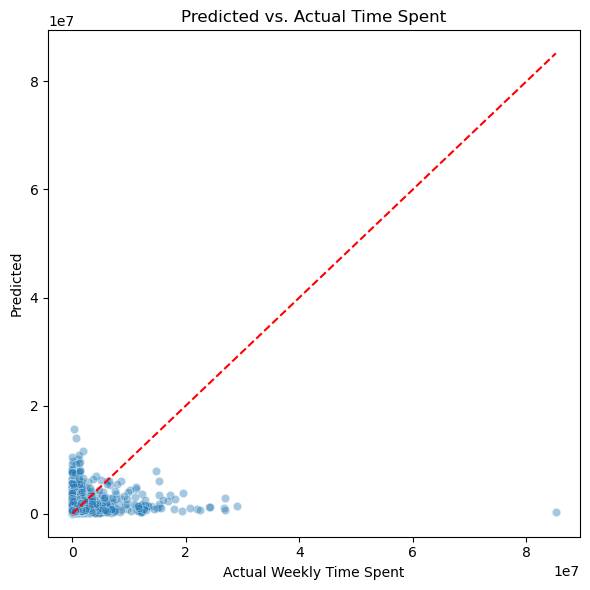

In [ ]:
best_pipe = make_pipeline(numeric_preprocessor, RandomForestRegressor(n_estimators=300, random_state=42))
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Weekly Time Spent")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual Time Spent")
plt.tight_layout()
plt.show()

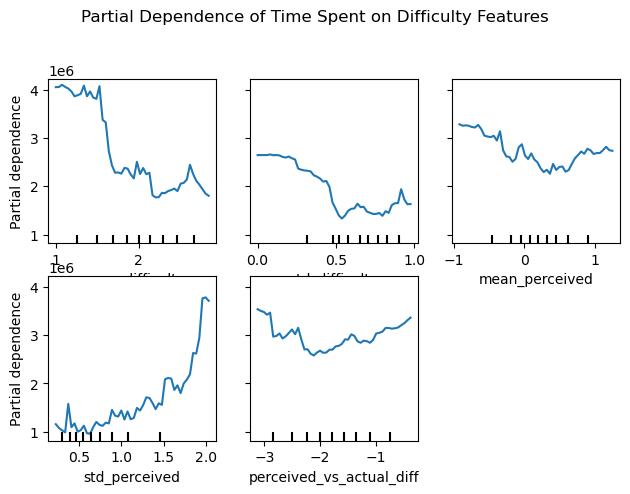

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_pipe, X, features=difficulty_features, grid_resolution=50)
plt.suptitle("Partial Dependence of Time Spent on Difficulty Features", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Features and target
X = df_model[features]
y = df_model['weekly_time_spent']

# Fit linear model
model_lr = LinearRegression()
model_lr.fit(X, y)

# Predict and calculate R^2
y_pred = model_lr.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² (explained variance): {r2:.3f}")

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)

y_pred = model_rf.predict(X)
r2 = r2_score(y, y_pred)

print(f"Random Forest R²: {r2:.3f}")

R² (explained variance): 0.028
Random Forest R²: 0.858


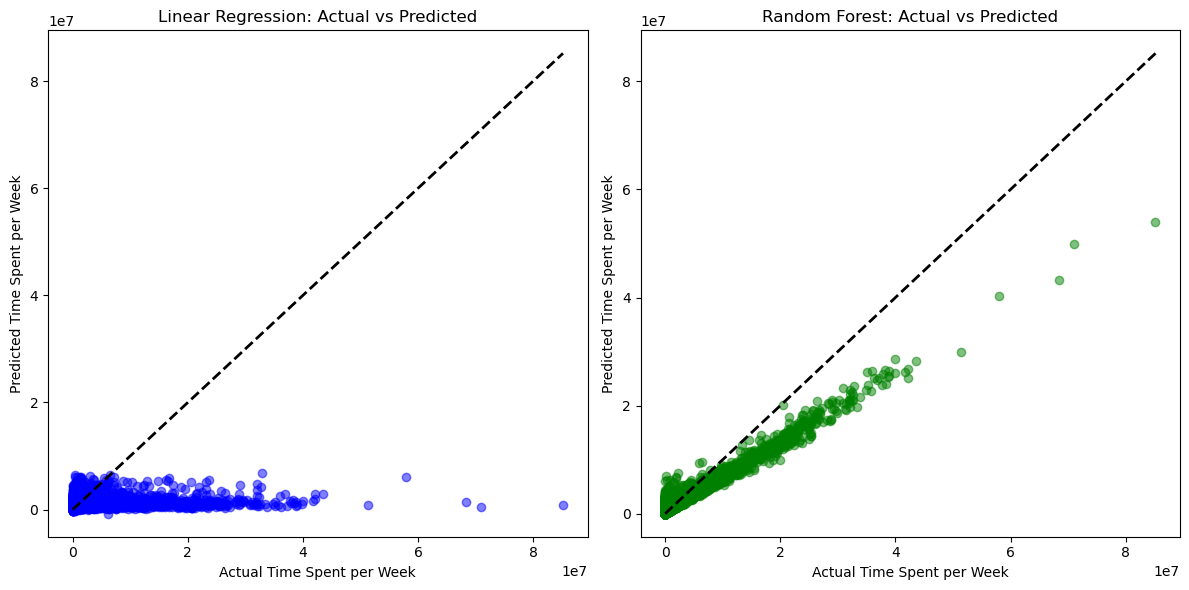

In [ ]:
# Linear Regression Predictions
y_pred_lr = model_lr.predict(X)

# Random Forest Predictions
y_pred_rf = model_rf.predict(X)

plt.figure(figsize=(12, 6))

# Plot Linear Regression vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_lr, color='blue', alpha=0.5, label='Linear Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Time Spent per Week')
plt.ylabel('Predicted Time Spent per Week')
plt.title('Linear Regression: Actual vs Predicted')

# Plot Random Forest vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_rf, color='green', alpha=0.5, label='Random Forest')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Time Spent per Week')
plt.ylabel('Predicted Time Spent per Week')
plt.title('Random Forest: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [ ]:
# Features and target
features = [
    'mean_difficulty', 'std_difficulty',
    'mean_perceived', 'std_perceived',
    'perceived_vs_actual_diff',
]
X = df_model[features]
y = df_model['weekly_time_spent']

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), features)
])

# Models
MODELS = {
    'Ridge' : Ridge(alpha=1.0),
    'Lasso' : Lasso(alpha=0.1),
}

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
results = []

for name, model in MODELS.items():
    r2s, rmses = [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe = make_pipeline(preprocessor, model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        r2s.append(r2_score(y_test, y_pred))
        rmses.append(mean_squared_error(y_test, y_pred, squared=False))

    results.append({
        'model': name,
        'R2_mean': np.mean(r2s),
        'RMSE_mean': np.mean(rmses)
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by='R2_mean', ascending=False)
display(results_df)


/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in ve

,model,R2_mean,RMSE_mean
0,Ridge,0.003307,3.366584e+06
1,Lasso,0.003305,3.366587e+06


### Separate Math & German

In [10]:
df_model.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,...,std_weekly_activity,week_start,week_period,engaged_next_week,mean_difficulty,std_difficulty,mean_perceived,std_perceived,perceived_minus_actual,perceived_vs_actual_diff
0,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.000000,0.0,0.0,0.0,...,141.95107,2021-06-27,2021-06-21/2021-06-27,0,2.625000,0.916125,-0.924275,2.234117,-0.924275,-3.549275
3,387604,2021-35,405,111.0,8.352444e+04,6.424957e+03,0.846154,118.0,3.0,0.0,...,141.95107,2021-08-29,2021-08-23/2021-08-29,1,2.000000,0.000000,-1.965535,0.500779,-1.965535,-3.965535
6,387604,2021-38,151,43.0,1.185300e+01,2.963250e+00,2.750000,14.0,0.0,0.0,...,141.95107,2021-09-19,2021-09-13/2021-09-19,1,1.833333,0.408248,-0.881810,0.274496,-0.881810,-2.715144
7,387604,2021-39,23,2.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,...,141.95107,2021-09-26,2021-09-20/2021-09-26,1,2.500000,1.000000,-0.452318,0.179803,-0.452318,-2.952318
10,387604,2021-44,249,45.0,1.910434e+07,5.423800e+01,20.000000,0.0,0.0,6.0,...,141.95107,2021-10-31,2021-10-25/2021-10-31,1,2.703704,1.102962,-1.103799,1.317934,-1.103799,-3.807503


In [11]:
topics = pd.read_csv('/Users/valentine/mlbd-2025/project/Lernnavi/Lernnavi_Data/topics_translated.csv')

In [16]:
topic_difficulty = difficulty.merge(
    topics[['id', 'math']],
    left_on='topic_id_x',
    right_on='id',
    how='left'
).drop(columns=['id'])

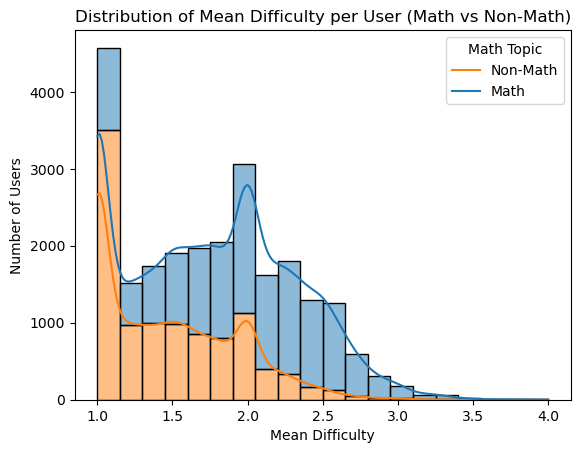

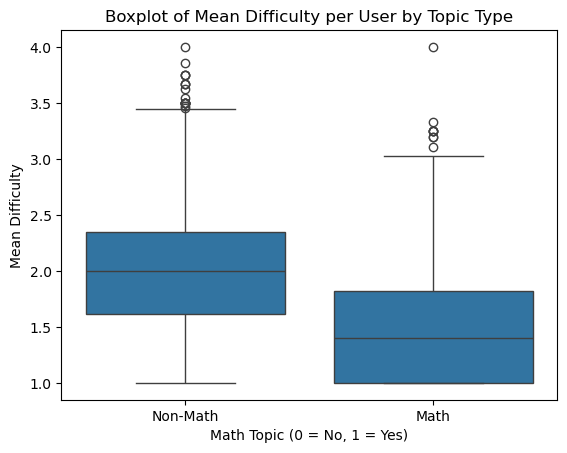

In [18]:
# Observe distribution of question difficulty 

# Mean difficulty
mean_diff = topic_difficulty.groupby(['user_id', 'year_week', 'math'])['difficulty'].mean().reset_index(name='mean_difficulty')

# Count of each difficulty
counts = pd.pivot_table(
    topic_difficulty,
    index=['user_id', 'year_week', 'math'],
    columns='difficulty',
    aggfunc='size',
    fill_value=0
).reset_index()

# Rename columns
counts.columns.name = None
counts = counts.rename(columns={
    1: 'difficulty_1_count',
    2: 'difficulty_2_count',
    3: 'difficulty_3_count',
    4: 'difficulty_4_count'
})

# Merge
weekly_difficulty = pd.merge(mean_diff, counts, on=['user_id', 'year_week', 'math'])
user_mean_difficulty = weekly_difficulty.groupby(['user_id', 'math'])['mean_difficulty'].mean().reset_index()

sns.histplot(data=user_mean_difficulty, x='mean_difficulty', hue='math', bins=20, kde=True, multiple='stack')
plt.title('Distribution of Mean Difficulty per User (Math vs Non-Math)')
plt.xlabel('Mean Difficulty')
plt.ylabel('Number of Users')
plt.legend(title='Math Topic', labels=['Non-Math', 'Math'])
plt.show()

sns.boxplot(data=user_mean_difficulty, x='math', y='mean_difficulty')
plt.title('Boxplot of Mean Difficulty per User by Topic Type')
plt.xlabel('Math Topic (0 = No, 1 = Yes)')
plt.ylabel('Mean Difficulty')
plt.xticks([0, 1], ['Non-Math', 'Math'])
plt.show()


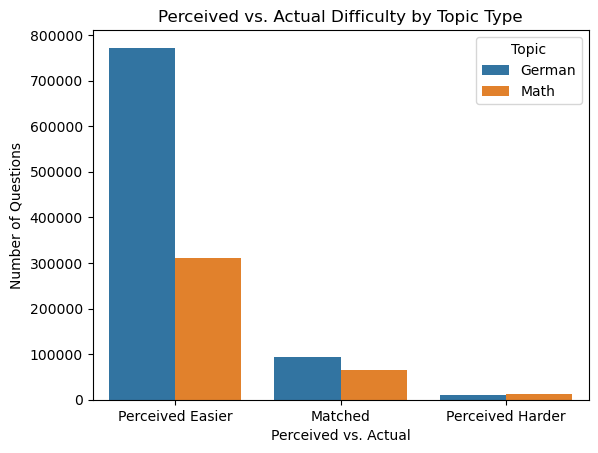

In [20]:
# Show perceived vs actual difficulty

threshold = 0.5

topic_difficulty['perceived_vs_actual'] = topic_difficulty.apply(
    lambda row: -1 if row['perceived_difficulty'] < row['difficulty'] - threshold
    else (1 if row['perceived_difficulty'] > row['difficulty'] + threshold 
    else 0),
    axis=1
)

# Create label names for readability
label_map = {-1: 'Perceived Easier', 0: 'Matched', 1: 'Perceived Harder'}
topic_difficulty['perceived_label'] = topic_difficulty['perceived_vs_actual'].map(label_map)

# Plot
sns.countplot(
    data=topic_difficulty,
    x='perceived_label',
    hue='math',
    order=['Perceived Easier', 'Matched', 'Perceived Harder']
)
plt.title('Perceived vs. Actual Difficulty by Topic Type')
plt.xlabel('Perceived vs. Actual')
plt.ylabel('Number of Questions')
plt.legend(title='Topic', labels=['German', 'Math'])
plt.grid(False)
plt.show()


In [23]:
# Aggregate actual and perceived difficulty per user-week
weekly_difficulty_stats = topic_difficulty.groupby(['user_id', 'year_week', 'math']).agg(
    mean_difficulty=('difficulty', 'mean'),
    std_difficulty=('difficulty', 'std'),
    mean_perceived=('perceived_difficulty', 'mean'),
    std_perceived=('perceived_difficulty', 'std'),
    perceived_minus_actual=('perceived_difficulty', lambda x: x.mean())  # we'll subtract later
).reset_index()

# Add perceived - actual difference
weekly_difficulty_stats['perceived_vs_actual_diff'] = (
    weekly_difficulty_stats['mean_perceived'] - weekly_difficulty_stats['mean_difficulty']
)

df_model = pd.merge(user_week_features, weekly_difficulty_stats, on=['user_id', 'year_week'], how='left').dropna()

# Define features and target
features = [
    'mean_difficulty',
    'std_difficulty',
    'mean_perceived',
    'std_perceived',
    'perceived_vs_actual_diff'
]

In [28]:
df_math     = df_model[df_model['math'] == 1].copy()
df_german = df_model[df_model['math'] == 0].copy()

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:, 1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append(f1_score(y.iloc[te], yhat))
    return np.mean(aucs), np.mean(f1s)

def run_modeling_pipeline(df_subset, name=''):
    X = df_subset[features]
    y = df_subset['engaged_next_week']
    
    tscv = TimeSeriesSplit(n_splits=5)
    rows = []

    numeric_cols = X.select_dtypes(include='number').columns

    pre = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
    ])

    for model_name, clf in MODELS.items():
        pipe = make_pipeline(pre, clf)
        auc2, f12 = cross_val(pipe, X, y, tscv)
        rows.append({'model': model_name, 'AUC': auc2, 'F1': f12})

    leader = pd.DataFrame(rows).sort_values('AUC', ascending=False).reset_index(drop=True)
    display(leader.style.background_gradient(cmap='viridis', subset=['AUC', 'F1']))
    
    best = leader.iloc[0]
    print(f"\nBest for {name}: {best['model']} AUC={best['AUC']:.3f}")
    
    # Fit on full train and evaluate on hold-out
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
    final_pipe = make_pipeline(pre, MODELS[best['model']])
    final_pipe.fit(X_train, y_train)
    prob = final_pipe.predict_proba(X_hold)[:, 1]
    
    RocCurveDisplay.from_predictions(y_hold, prob)
    plt.title(f'ROC – hold-out ({name})'); plt.show()

    PrecisionRecallDisplay.from_predictions(y_hold, prob)
    plt.title(f'Precision-Recall – hold-out ({name})'); plt.show()

MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=600, class_weight='balanced', random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42)
}

,model,AUC,F1
0,Logistic,0.527979,0.480485
1,GradientBoost,0.520784,0.250516
2,RandomForest,0.510139,0.341115
3,Dummy,0.500000,0.000000



Best for Math: Logistic AUC=0.528


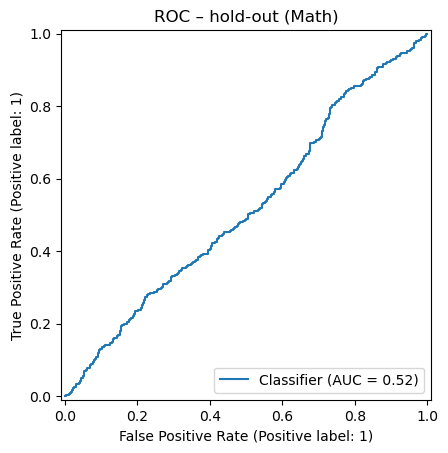

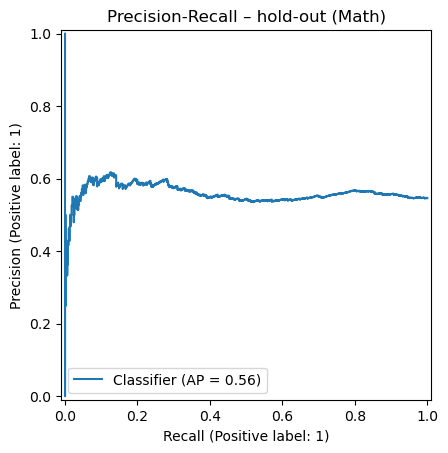

,model,AUC,F1
0,RandomForest,0.539835,0.466928
1,GradientBoost,0.539731,0.455138
2,Logistic,0.535804,0.518672
3,Dummy,0.500000,0.000000



Best for Non-Math: RandomForest AUC=0.540


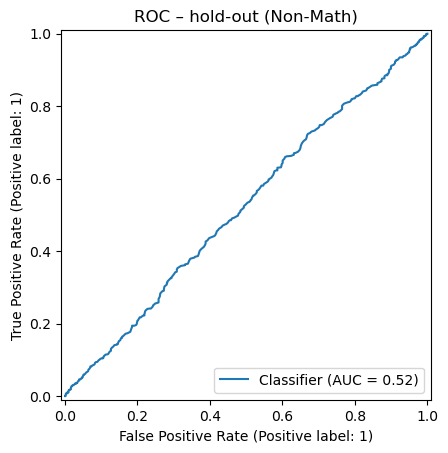

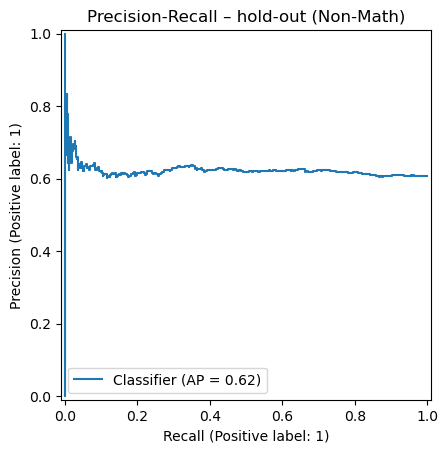

In [29]:
run_modeling_pipeline(df_math, name='Math')
run_modeling_pipeline(df_german, name='Non-Math')

In [38]:
def run_full_pipeline(df, name="All"):
    print(f"\n====== Modeling: {name} ======\n")

    # Drop ID columns
    X = df.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
    y = df['engaged_next_week']

    # Select only numeric features
    numeric_cols = X.select_dtypes(include='number').columns
    pre = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
    ])

    # TimeSeries CV
    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []
    best_auc = -np.inf
    best_pipe = None
    best_model_name = None

    for name_model, clf in MODELS.items():
        pipe = make_pipeline(pre, clf)
        auc, f1 = cross_val(pipe, X, y, tscv)
        results.append({'model': name_model, 'AUC': auc, 'F1': f1})
        if auc > best_auc:
            best_auc = auc
            best_pipe = pipe
            best_model_name = name_model

    # Leaderboard
    leaderboard = pd.DataFrame(results).sort_values('AUC', ascending=False).reset_index(drop=True)
    display(leaderboard.style.background_gradient(cmap='YlGnBu', subset=['AUC', 'F1']))

    # Train on holdout
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
    best_pipe.fit(X_train, y_train)
    prob = best_pipe.predict_proba(X_hold)[:, 1]

    RocCurveDisplay.from_predictions(y_hold, prob)
    plt.title(f'ROC – hold-out ({name})')
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_hold, prob)
    plt.title(f'Precision-Recall – hold-out ({name})')
    plt.show()

    # Permutation importance
    best_pipe.fit(X, y)
    final_model = best_pipe.steps[-1][1]
    preprocessor = best_pipe.named_steps['columntransformer']
    X_processed = preprocessor.transform(X)

    r = permutation_importance(final_model, X_processed, y, n_repeats=10, random_state=42, n_jobs=-1)
    feature_names = preprocessor.get_feature_names_out()
    sorted_idx = r.importances_mean.argsort()[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=r.importances_mean[sorted_idx][:20], y=feature_names[sorted_idx][:20])
    plt.title(f"Top 20 Feature Importances (Permutation) – {name}")
    plt.xlabel("Mean Decrease in AUC")
    plt.tight_layout()
    plt.show()

    return leaderboard, pd.DataFrame({
    'feature': feature_names[sorted_idx],
    'importance': r.importances_mean[sorted_idx]
}), best_pipe



====== Modeling: Math ======



,model,AUC,F1
0,RandomForest,0.772578,0.624557
1,GradientBoost,0.772446,0.614406
2,Logistic,0.619972,0.574018
3,Dummy,0.500000,0.000000


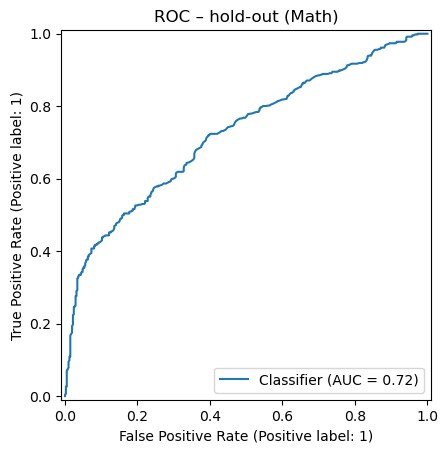

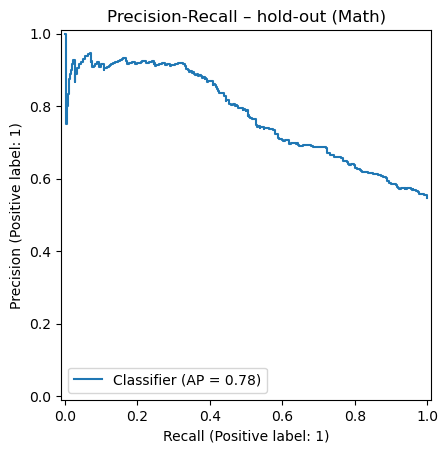

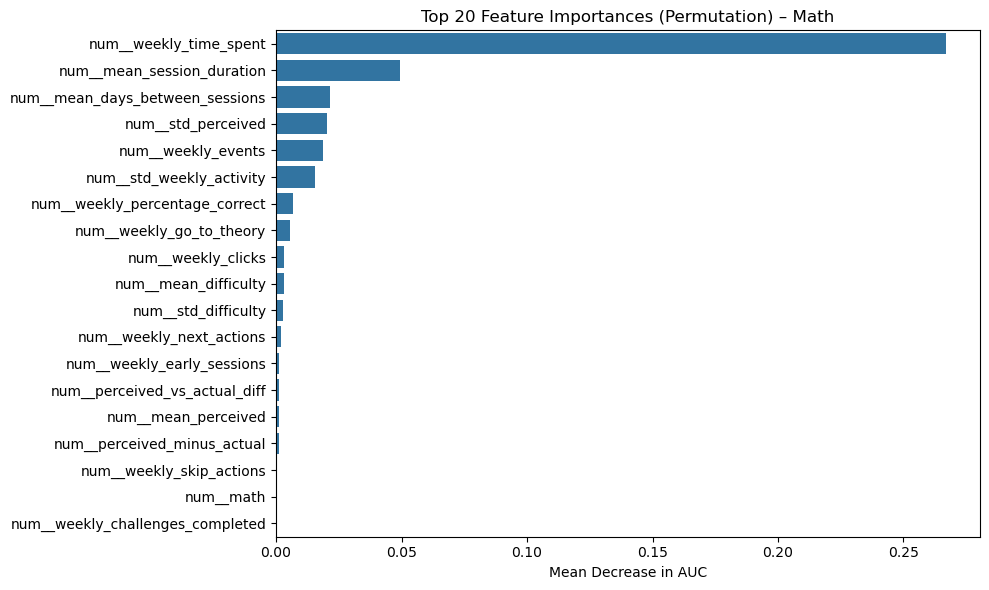


====== Modeling: German ======



,model,AUC,F1
0,GradientBoost,0.769186,0.655330
1,RandomForest,0.767029,0.660458
2,Logistic,0.610608,0.631413
3,Dummy,0.500000,0.000000


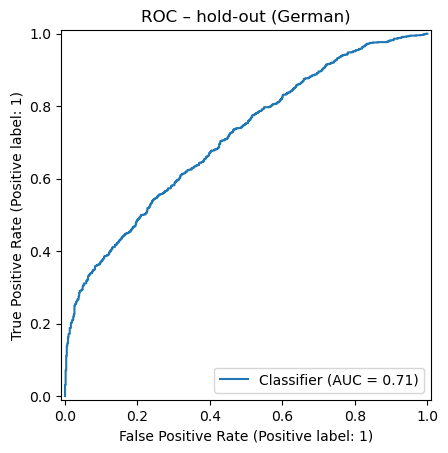

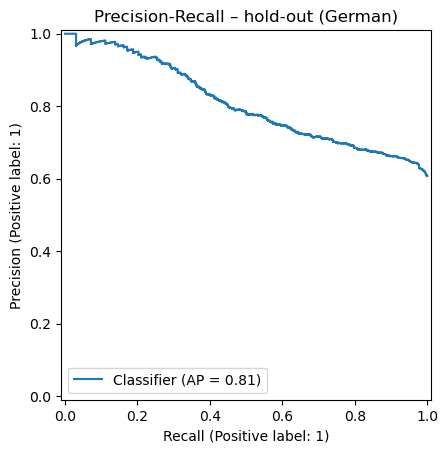

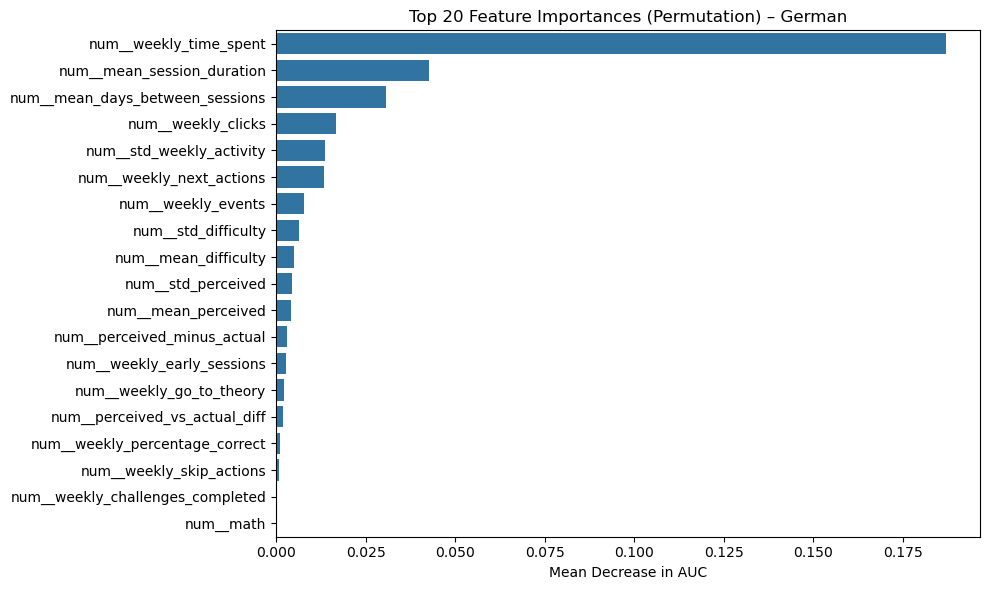

In [39]:
leader_math, feat_imp_math, best_pipe_math = run_full_pipeline(df_math, name='Math')
leader_german, feat_imp_german, best_pipe_german = run_full_pipeline(df_german, name='German')

/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_65704/3206973359.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


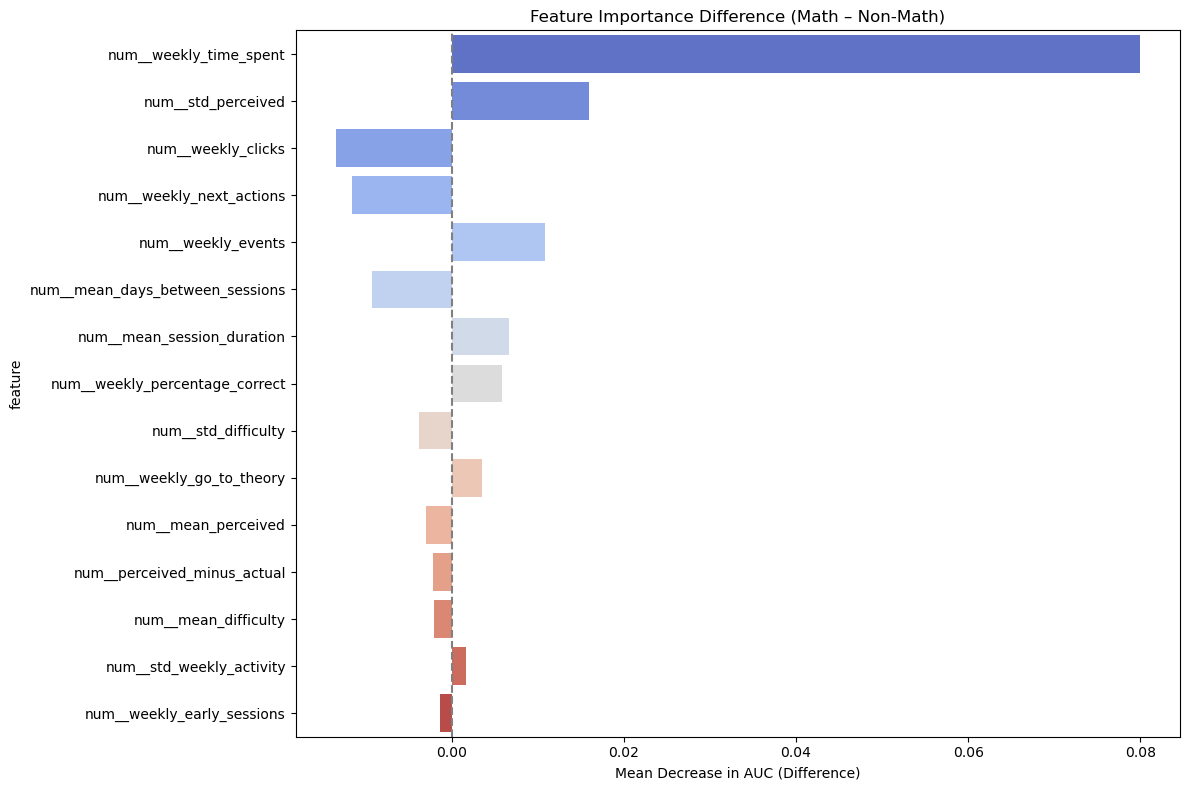

In [32]:
# Merge feature importance
fi_compare = pd.merge(fi_math, fi_nonmath, on='feature', how='outer', suffixes=('_math', '_nonmath'))

# Compute difference
fi_compare['importance_diff'] = fi_compare['importance_math'] - fi_compare['importance_nonmath']
fi_compare = fi_compare.sort_values('importance_diff', key=abs, ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=fi_compare.head(15),
    y='feature',
    x='importance_diff',
    palette='coolwarm',
    orient='h'
)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Feature Importance Difference (Math – Non-Math)")
plt.xlabel("Mean Decrease in AUC (Difference)")
plt.tight_layout()
plt.show()


In [35]:
def plot_side_by_side_feature_importances(fi_math, fi_nonmath, top_n=20):
    """
    Plot side-by-side barplot of permutation feature importances for Math and Non-Math groups.
    
    Parameters:
    - fi_math: pd.DataFrame with columns ['feature', 'importance'] for Math group
    - fi_nonmath: pd.DataFrame with columns ['feature', 'importance'] for Non-Math group
    - top_n: int, number of top features to show based on average importance across groups
    """
    fi_math = fi_math.copy()
    fi_nonmath = fi_nonmath.copy()
    
    fi_math['group'] = 'Math'
    fi_nonmath['group'] = 'German'
    
    fi_combined = pd.concat([fi_math, fi_nonmath], ignore_index=True)
    
    # Select top N features by average importance across both groups
    top_features = (
        fi_combined.groupby('feature')['importance']
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )
    
    fi_top = fi_combined[fi_combined['feature'].isin(top_features)]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=fi_top,
        y='feature',
        x='importance',
        hue='group',
        palette=['#1f77b4', '#ff7f0e']
    )
    plt.title(f"Top {top_n} Feature Importances: Math vs. Non-Math")
    plt.xlabel("Mean Decrease in AUC (Permutation Importance)")
    plt.ylabel("Feature")
    plt.legend(title='Group')
    plt.tight_layout()
    plt.show()

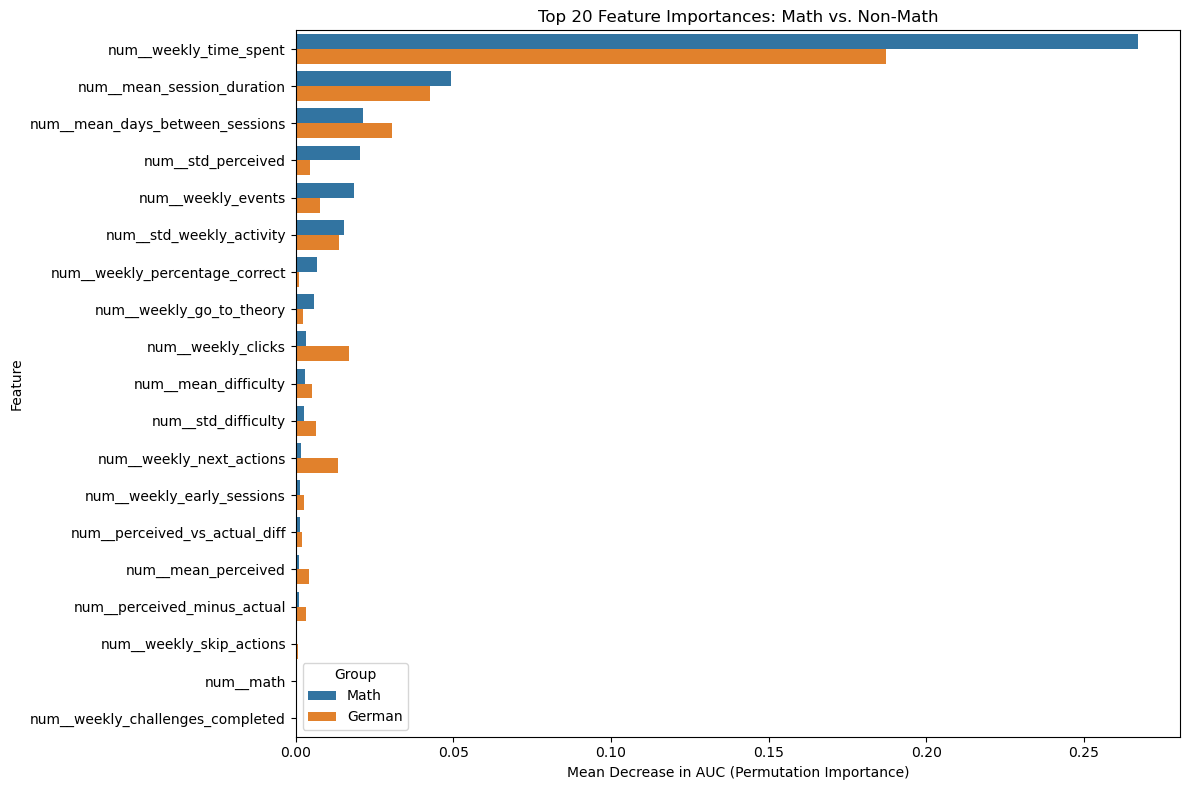

In [ ]:
plot_side_by_side_feature_importances(fi_math, fi_nonmath, top_n=20)

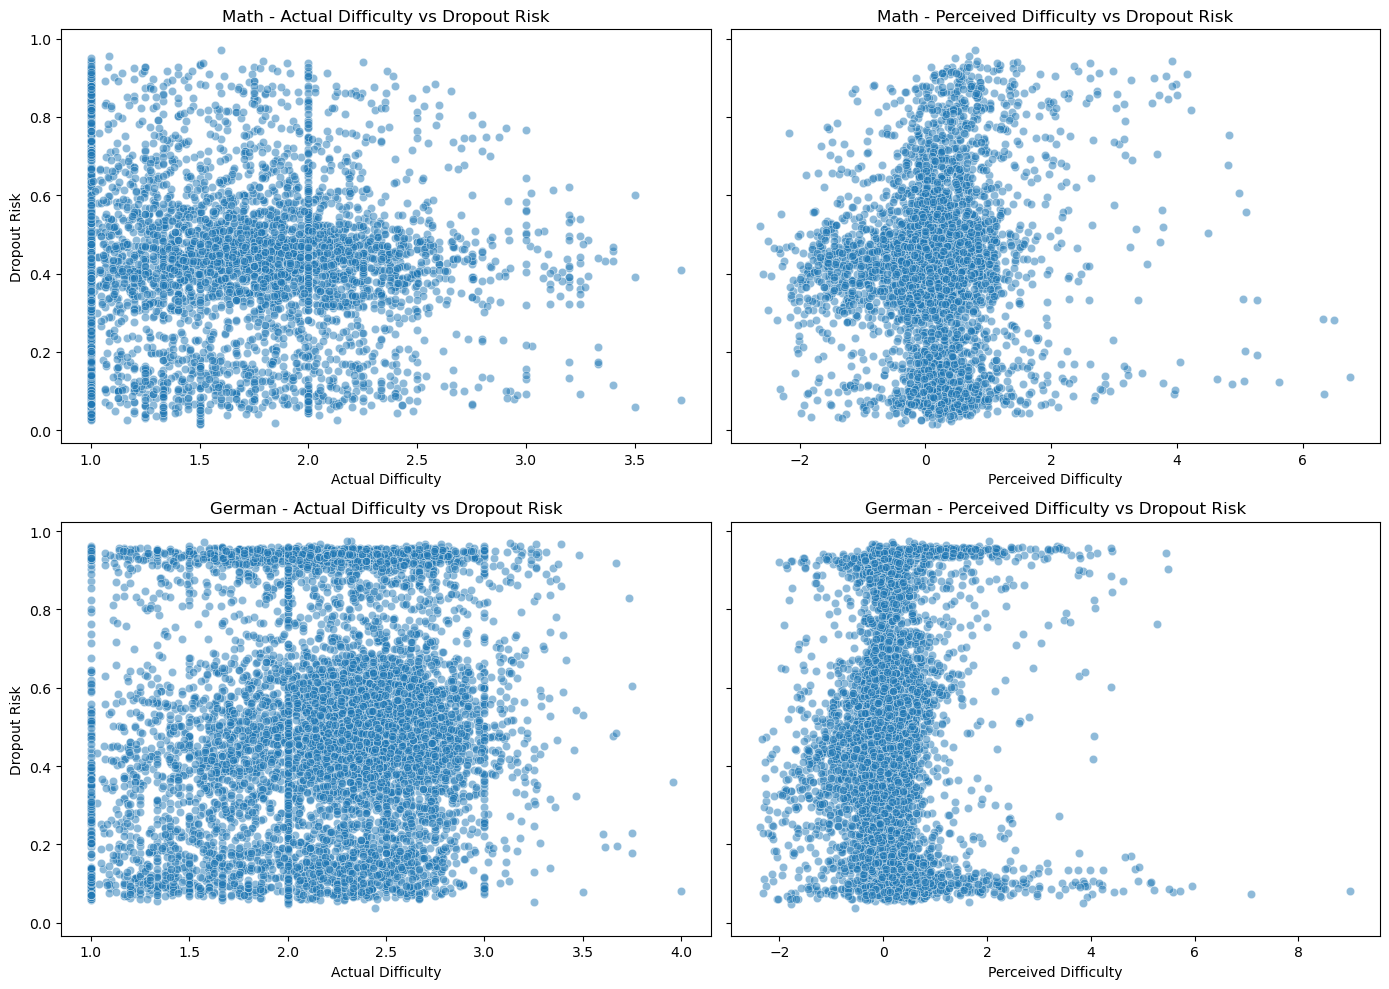

In [41]:
# Copy original dataframes (or subset used for modeling)
df_math_viz = df_math.copy()
df_german_viz = df_german.copy()

# Prepare features for prediction (drop IDs and target)
X_math = df_math_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
X_german = df_german_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])

# Predict dropout risk using the best pipelines
df_math_viz['dropout_risk'] = best_pipe_math.predict_proba(X_math)[:, 1]
df_german_viz['dropout_risk'] = best_pipe_german.predict_proba(X_german)[:, 1]

# Add mean perceived difficulty from difficulty dataframe
mean_perceived = difficulty.groupby(['user_id', 'year_week'])['perceived_difficulty'].mean().reset_index()
df_math_viz = df_math_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')
df_german_viz = df_german_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')

# Add mean actual difficulty
mean_actual = difficulty.groupby(['user_id', 'year_week'])['difficulty'].mean().reset_index()
df_math_viz = df_math_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')
df_german_viz = df_german_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')

# Plotting side-by-side scatterplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Math - Actual Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_math_viz,
    x='difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[0, 0]
)
axes[0, 0].set_title('Math - Actual Difficulty vs Dropout Risk')
axes[0, 0].set_xlabel('Actual Difficulty')
axes[0, 0].set_ylabel('Dropout Risk')

# Math - Perceived Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_math_viz,
    x='perceived_difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[0, 1]
)
axes[0, 1].set_title('Math - Perceived Difficulty vs Dropout Risk')
axes[0, 1].set_xlabel('Perceived Difficulty')
axes[0, 1].set_ylabel('')

# German - Actual Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_german_viz,
    x='difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[1, 0]
)
axes[1, 0].set_title('German - Actual Difficulty vs Dropout Risk')
axes[1, 0].set_xlabel('Actual Difficulty')
axes[1, 0].set_ylabel('Dropout Risk')

# German - Perceived Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_german_viz,
    x='perceived_difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[1, 1]
)
axes[1, 1].set_title('German - Perceived Difficulty vs Dropout Risk')
axes[1, 1].set_xlabel('Perceived Difficulty')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()


/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_65704/1545180652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('diff_bin').agg(
/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_65704/1545180652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('diff_bin').agg(
/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_65704/1545180652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 

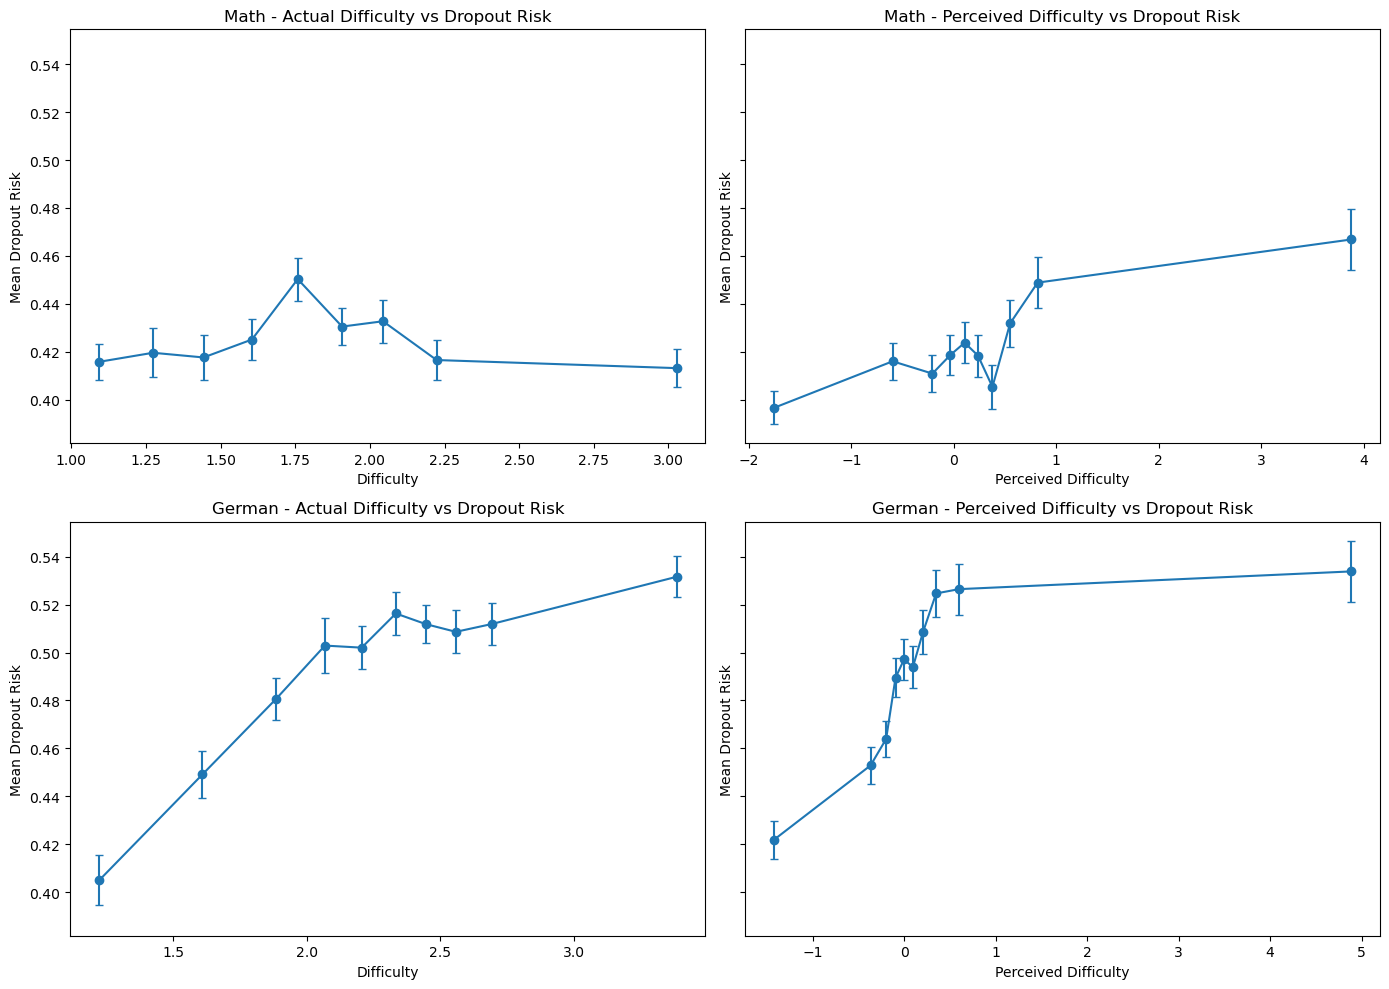

In [42]:
def plot_binned_risk(df, difficulty_col, ax, title):
    # Create bins (e.g., 10 bins)
    df['diff_bin'] = pd.qcut(df[difficulty_col], q=10, duplicates='drop')
    
    # Aggregate: mean dropout risk and std in each bin
    agg = df.groupby('diff_bin').agg(
        mean_risk=('dropout_risk', 'mean'),
        std_risk=('dropout_risk', 'std'),
        count=('dropout_risk', 'count')
    ).reset_index()
    
    # Use bin midpoints for plotting
    agg['bin_mid'] = agg['diff_bin'].apply(lambda x: x.mid)
    
    # Plot with error bars
    ax.errorbar(
        agg['bin_mid'], agg['mean_risk'],
        yerr=agg['std_risk'] / np.sqrt(agg['count']),  # standard error
        fmt='o-', capsize=3
    )
    ax.set_title(title)
    ax.set_xlabel(difficulty_col.replace('_', ' ').title())
    ax.set_ylabel('Mean Dropout Risk')

# Prepare the data as before
df_math_viz = df_math.copy()
df_german_viz = df_german.copy()

X_math = df_math_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
X_german = df_german_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])

df_math_viz['dropout_risk'] = best_pipe_math.predict_proba(X_math)[:, 1]
df_german_viz['dropout_risk'] = best_pipe_german.predict_proba(X_german)[:, 1]

mean_perceived = difficulty.groupby(['user_id', 'year_week'])['perceived_difficulty'].mean().reset_index()
mean_actual = difficulty.groupby(['user_id', 'year_week'])['difficulty'].mean().reset_index()

df_math_viz = df_math_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')
df_math_viz = df_math_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')

df_german_viz = df_german_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')
df_german_viz = df_german_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')

# Plotting binned risk
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

plot_binned_risk(df_math_viz, 'difficulty', axes[0, 0], 'Math - Actual Difficulty vs Dropout Risk')
plot_binned_risk(df_math_viz, 'perceived_difficulty', axes[0, 1], 'Math - Perceived Difficulty vs Dropout Risk')
plot_binned_risk(df_german_viz, 'difficulty', axes[1, 0], 'German - Actual Difficulty vs Dropout Risk')
plot_binned_risk(df_german_viz, 'perceived_difficulty', axes[1, 1], 'German - Perceived Difficulty vs Dropout Risk')

plt.tight_layout()
plt.show()